#Import libraries

In [ ]:
import os
import requests
import zipfile
import sys
import pandas as pd
import re
from functools import reduce
import gensim.downloader as gloader
from tqdm.notebook import tqdm
from itertools import chain
import numpy as np
import random
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, GRU, Embedding, TimeDistributed, GlobalAveragePooling1D, Reshape, concatenate, add, average
from tensorflow.math import reduce_mean
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning) #just get rid of some alerts

#Download Data

In [ ]:
#from assignment
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

#Load Data

In [ ]:
#loading data in 3 sets, removing the first unnamed column
train_data = pd.read_csv('dataset/train_pairs.csv', index_col=[0])
val_data = pd.read_csv('dataset/val_pairs.csv', index_col=[0])
test_data = pd.read_csv('dataset/test_pairs.csv', index_col=[0])
print(train_data.shape)
train_data.head()

(121740, 4)


,Claim,Evidence,ID,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES


#Text Cleaning

In [ ]:
#we define the operations to do in order to "clean" the text. Applying the removal of multiple blank spaces after the first step of substitution gave better results than simultaneously
rr=random.randint(0,1000)
sample_before=train_data["Evidence"][rr]
exclusionList=["-[\w]+-",'[^0-9a-z \t]',"\t",'(\d+)\t']
exclusions = '|'.join(exclusionList)

cleaning=[
lambda x: x.lower(),
lambda x: re.sub(exclusions, ' ', x),
lambda x: re.sub(" +", ' ', x),
lambda x: x.strip()
]

process_cleaning = lambda x: reduce(lambda k, f: f(k), cleaning, x)

In [ ]:
def apply_cleaning(sett):  
  #create a list of words without repetitions keeping the same order, quite long process but cleans a lot of repetitions and transforms the max seq lenght from 220 to 95
  for i in ["Claim","Evidence"]:
    sett[i] = sett[i].apply(process_cleaning)
    for k in tqdm(range(len(sett[i]))):
      D=list()
      [D.append(b) for b in sett[i][k].split(" ") if b not in D]
      sett[i][k]=' '.join(D)

apply_cleaning(train_data)
apply_cleaning(val_data)
apply_cleaning(test_data)
sample_after=train_data["Evidence"][rr]

  0%|          | 0/121740 [00:00<?, ?it/s]

  0%|          | 0/121740 [00:00<?, ?it/s]

  0%|          | 0/7165 [00:00<?, ?it/s]

  0%|          | 0/7165 [00:00<?, ?it/s]

  0%|          | 0/7189 [00:00<?, ?it/s]

  0%|          | 0/7189 [00:00<?, ?it/s]

In [ ]:
print(sample_before)
print(sample_after)

1	He starred in several television series over more than five decades , including such popular roles as Bret Maverick in the 1950s western comedy series Maverick and Jim Rockford in The Rockford Files , and played leading roles in more than 50 theatrical films , including The Great Escape -LRB- 1963 -RRB- with Steve McQueen , Paddy Chayefsky 's The Americanization of Emily -LRB- 1964 -RRB- , Grand Prix -LRB- 1966 -RRB- , Blake Edwards ' Victor/Victoria -LRB- 1982 -RRB- , Murphy 's Romance -LRB- 1985 -RRB- , for which he received an Academy Award nomination , Space Cowboys -LRB- 2000 -RRB- with Clint Eastwood , and The Notebook -LRB- 2004 -RRB- .	Bret Maverick	Maverick (TV series)#James Garner as Bret Maverick	western	Western (genre)	Maverick	Maverick (TV series)	Jim Rockford	Jim Rockford (television character)	The Rockford Files	The Rockford Files	The Great Escape	The Great Escape (film)	Steve McQueen	Steve McQueen	Paddy Chayefsky	Paddy Chayefsky	The Americanization of Emily	The Americ

#Embedding

In [ ]:
EMBEDDING_DIMENSION="50"
embedding_model=gloader.load(f"glove-wiki-gigaword-{EMBEDDING_DIMENSION}")

##Build vocabulary and embedding matrix

In [ ]:
#similar to assignment 1
def build_voc(sett):
  l=set()
  for i in sett["Claim"]:
    for j in i.split(" "):
      l.add(j)
  for i in sett["Evidence"]:
    for j in i.split(" "):
      l.add(j)
  l=list(l)
  vocabulary={}
  for k in tqdm(range(0,len(l))):
      if l[k] not in vocabulary.values():
        vocabulary[k+1]=l[k]
  return vocabulary

voc=build_voc(train_data)
print(f"Voc size after train: {len(voc)}")
#print(voc)

oov1=set(voc.values()).difference(set(embedding_model.vocab.keys()))
print("The training set contains: "+str(len(oov1))+" oov words")

  0%|          | 0/32333 [00:00<?, ?it/s]

Voc size after train: 32333
The training set contains: 2312 oov words


In [ ]:
#from tutorials
def build_embedding_matrix(embedding_model, voc):
  embedding_matrix = np.zeros((len(voc) + 1, embedding_model.vector_size), dtype = np.float32) 
  for idx, word in voc.items():
      try:
          embedding_vector = embedding_model[word]
      except (KeyError, TypeError):
          embedding_vector = np.random.uniform(-0.01,0.01,embedding_model.vector_size)
      embedding_matrix[idx] = embedding_vector
  return embedding_matrix

embedding_matrix=build_embedding_matrix(embedding_model,voc)
print(embedding_matrix.shape)

(32334, 50)


#Update vocabulary and embedding matrix for validation and test set

In [ ]:
def update_voc(sett,voc,embedding_model,embedding_matrix):
  ##finding oov
      l=[]
      for i in sett["Claim"]:
        for j in i.split(" "):
          l.append(j)
      for i in sett["Evidence"]:
        for j in i.split(" "):
          l.append(j)
      l=(set(l)) #uniques
      known_words=set(embedding_model.vocab.keys()).union(set(voc.values()))
      oov = l.difference(known_words)
      print("Found other: "+str(len(list(oov)))+" oov words")

      #computing new vocabulary
      print(f"Words in the set: {len(l)}")
      new_words=l.difference(set(voc.values()))
      base=len(voc.keys())
      for i in tqdm(range(0,len(list(new_words)))):
        voc[base+i+1]=list(new_words)[i]

      if len(new_words) > 0:
        for k in tqdm(new_words):
          try:
            embedding_vector = embedding_model[k]
          except (KeyError, TypeError):
            embedding_vector = np.random.uniform(-0.01,0.01,embedding_model.vector_size)
          
          embedding_matrix = np.vstack((embedding_matrix, embedding_vector))
      print("Embedding matrix shape: " + str(embedding_matrix.shape))
      return embedding_matrix,voc


print("For validation set: \n")
embedding_matrix, voc = update_voc(val_data,voc,embedding_model,embedding_matrix)

print("For test set: \n")
embedding_matrix, voc = update_voc(test_data,voc,embedding_model,embedding_matrix)

For validation set: 

Found other: 193 oov words
Words in the set: 8882


  0%|          | 0/1485 [00:00<?, ?it/s]

  0%|          | 0/1485 [00:00<?, ?it/s]

Embedding matrix shape: (33819, 50)
For test set: 

Found other: 235 oov words
Words in the set: 9918


  0%|          | 0/1752 [00:00<?, ?it/s]

  0%|          | 0/1752 [00:00<?, ?it/s]

Embedding matrix shape: (35571, 50)


#Data preparation

In [ ]:
#find the lenght of the longest sentence
MAX_SEQ_LENGTH = 0
for i in ["Evidence","Claim"]:
  for j in pd.concat([train_data[i],val_data[i],test_data[i]]):
    p=j.split(" ")
    if len(p) > MAX_SEQ_LENGTH:
      print(j)
      MAX_SEQ_LENGTH= len(p)
print(MAX_SEQ_LENGTH)

hemsworth has also appeared in the science fiction action film star trek 2009 thriller adventure a perfect getaway horror comedy cabin woods 2012 dark fantasy snow white and huntsman war red dawn biographical sports drama rush 2013
many victims were said to have been killed in a mixed use building he owned located about 3 mi west of the 1893 chicago world s fair and hotel though evidence suggests that portion was never truly open for business
he starred in several television series over more than five decades including such popular roles as bret maverick the 1950s western comedy and jim rockford files played leading 50 theatrical films great escape 1963 with steve mcqueen paddy chayefsky s americanization of emily 1964 grand prix 1966 blake edwards victor victoria 1982 murphy romance 1985 for which received an academy award nomination space cowboys 2000 clint eastwood notebook 2004 tv james garner genre character film awards
he has voiced joel in the last of us booker dewitt bioshock i

In [ ]:
#turn id:label to label:id
def switch_voc(d):
  return dict([(value, key) for key, value in d.items()])

#create a dict for labels and than swap it
label_dict={}
labels=list(set(train_data['Label']))
NUM_OF_LABELS = len(labels) + 1 #+1 for the model
for i in range(NUM_OF_LABELS-1):
  label_dict[i]=labels[i]
label_dict2=switch_voc(label_dict)
voc2=switch_voc(voc)
print(label_dict2)

{'REFUTES': 0, 'SUPPORTS': 1}


In [ ]:
def prepare_matrix(sett):
  #create matrix of ints representing the dataframe using voc2
  mat_evidence = [[voc2[sett['Evidence'][i].split(" ")[k]] for k in range(len(sett['Evidence'][i].split(" ")))] for i in tqdm(range(len(sett)))] 
  mat_claim = [[voc2[sett['Claim'][i].split(" ")[k]] for k in range(len(sett['Claim'][i].split(" ")))] for i in tqdm(range(len(sett)))] 

  mat_evidence =np.asarray([np.array(k) for k in mat_evidence],dtype=object)
  mat_claim =np.asarray([np.array(k) for k in mat_claim],dtype=object)

  mat_evidence = pad_sequences(mat_evidence, maxlen = MAX_SEQ_LENGTH, padding = 'post', truncating = 'post')  #pad to be uniform
  mat_claim = pad_sequences(mat_claim, maxlen = MAX_SEQ_LENGTH, padding = 'post', truncating = 'post')
  return mat_evidence, mat_claim
  
print("Train:")
train_mat_evidence, train_mat_claim=prepare_matrix(train_data)
print("Val:")
val_mat_evidence, val_mat_claim=prepare_matrix(val_data)
print("Test:")
test_mat_evidence, test_mat_claim=prepare_matrix(test_data)

Train:


  0%|          | 0/121740 [00:00<?, ?it/s]

  0%|          | 0/121740 [00:00<?, ?it/s]

Val:


  0%|          | 0/7165 [00:00<?, ?it/s]

  0%|          | 0/7165 [00:00<?, ?it/s]

Test:


  0%|          | 0/7189 [00:00<?, ?it/s]

  0%|          | 0/7189 [00:00<?, ?it/s]

In [ ]:
print(train_mat_evidence.shape)
print(val_mat_evidence.shape)

(121740, 94)
(7165, 94)


In [ ]:
#create matrixes of ints for the labels
train_labels = np.array([label_dict2[i] for i in train_data["Label"]])
val_labels = np.array([label_dict2[i] for i in val_data["Label"]])
test_labels= np.array([label_dict2[i] for i in test_data["Label"]])

#Models

In [ ]:
#input and embedding layers for both claims and evidences
claim_input = Input(shape = (MAX_SEQ_LENGTH, ))
claim_embedding = Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = int(EMBEDDING_DIMENSION),
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False)(claim_input)

evidence_input = Input(shape = (MAX_SEQ_LENGTH, ) )
evidence_embedding = Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = int(EMBEDDING_DIMENSION),
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False)(evidence_input)

#during training the models considering cos_sim used to perform better, in the followings cos_sim is always cosnidered               
cos_sim=layers.Dot(axes=(1), normalize=True)([layers.Flatten()(claim_embedding),layers.Flatten()(evidence_embedding)])
print(cos_sim)
print(evidence_embedding.shape)
print(claim_embedding.shape)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dot/Squeeze:0', description="created by layer 'dot'")
(None, 94, 50)
(None, 94, 50)


1.Encode token sequences via a RNN and take the last state as the sentence embedding

In [ ]:
claim_lstm = Bidirectional(LSTM(32, return_sequences = False, dropout = 0.2, recurrent_dropout = 0.2))(claim_embedding)
evidence_lstm = Bidirectional(LSTM(32, return_sequences = False, dropout = 0.2, recurrent_dropout = 0.2))(evidence_embedding)
print(claim_lstm.shape)

(None, 64)


2.Encode token sequences via a RNN and average all the output states.

In [ ]:
claim_lstm_averaged = GlobalAveragePooling1D(data_format="channels_last") (
    Bidirectional(LSTM(32, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2))(claim_embedding)
)
evidence_lstm_averaged = GlobalAveragePooling1D(data_format="channels_last") (
    Bidirectional(LSTM(32, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2))(evidence_embedding)
)
print(claim_lstm.shape)

(None, 64)


3.Encode token sequences via a simple MLP layer

In [ ]:
claim_mlp = Dense(EMBEDDING_DIMENSION, activation = 'softmax') ( Reshape((MAX_SEQ_LENGTH * int(EMBEDDING_DIMENSION), )) (claim_embedding) )
evidence_mlp = Dense(EMBEDDING_DIMENSION, activation = 'softmax') ( Reshape((MAX_SEQ_LENGTH * int(EMBEDDING_DIMENSION), )) (evidence_embedding) )
print(claim_mlp.shape)
print(evidence_mlp.shape)

(None, 50)
(None, 50)


4.Compute the sentence embedding as the mean of its token embeddings (bag of vectors).

In [ ]:
claim_bag = reduce_mean(claim_embedding, axis = 1)
evidence_bag = reduce_mean(evidence_embedding, axis = 1)
print(claim_bag.shape)
print(evidence_bag.shape)

(None, 50)
(None, 50)


##Merging multi-inputs

In [ ]:
#merge_conc is the one who performed better during training, for the final models concat is used
def merge_conc(x,y,c=False):
  if c:
    return concatenate([x,y,cos_sim])
  else:
    return concatenate([x,y])  
def merge_add(x,y,c=False):
  if c:
    return concatenate([add([x,y]),cos_sim])
  else:
    return add([x,y])
def merge_avg(x,y,c=False):
  if c:
    return concatenate([average([x,y]),cos_sim])
  else:
    return average([x,y])


##Training

In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100000,
    decay_rate=0.9,
    staircase=True)

earlystop = [EarlyStopping(monitor = "val_loss", restore_best_weights=True, verbose = 1, patience = 3, mode = "auto")]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 94, 50)       1778550     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 94, 50)       1778550     ['input_2[0][0]']                
                                                                                              

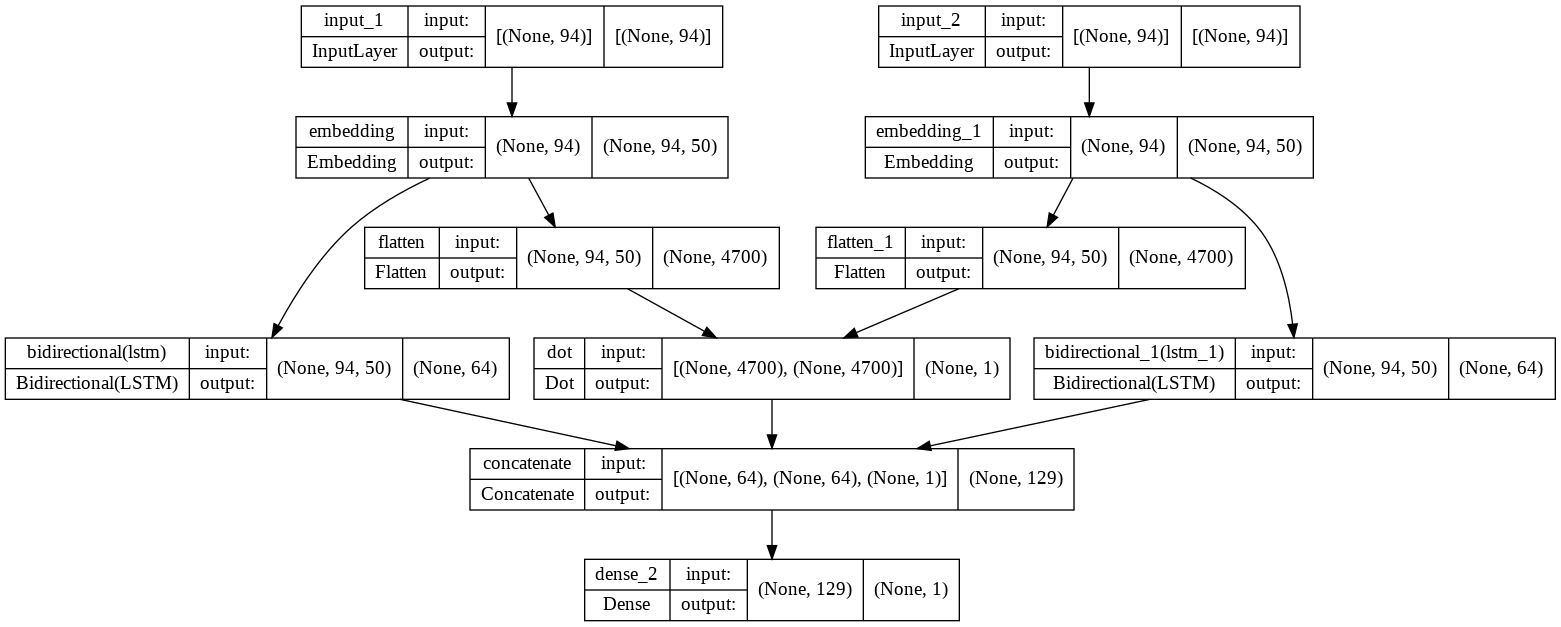

In [ ]:
#lstm last state, merge conc, cos
merged=merge_conc(claim_lstm,evidence_lstm, c=True)
final_layer = Dense(1, activation="sigmoid")(merged)

model = Model(inputs = (claim_input, evidence_input), outputs = final_layer)
model.compile(loss = BinaryCrossentropy(from_logits=False), optimizer = Adam(lr_schedule), metrics = ['binary_accuracy'])

model.summary()

plot_model(model, show_shapes = True)

In [ ]:
model.fit(x = (train_mat_claim, train_mat_evidence), y = train_labels,
                   validation_data = ((val_mat_claim, val_mat_evidence), val_labels),
                   batch_size = 128, epochs = 10, callbacks = earlystop)

Epoch 1/10
952/952 [==============================] - 705s 723ms/step - loss: 0.4475 - binary_accuracy: 0.8067 - val_loss: 0.6110 - val_binary_accuracy: 0.6830
Epoch 2/10
952/952 [==============================] - 696s 731ms/step - loss: 0.4055 - binary_accuracy: 0.8281 - val_loss: 0.5988 - val_binary_accuracy: 0.6927
Epoch 3/10
952/952 [==============================] - 690s 725ms/step - loss: 0.3963 - binary_accuracy: 0.8322 - val_loss: 0.5889 - val_binary_accuracy: 0.7020
Epoch 4/10
952/952 [==============================] - 691s 726ms/step - loss: 0.3911 - binary_accuracy: 0.8341 - val_loss: 0.5675 - val_binary_accuracy: 0.7029
Epoch 5/10
952/952 [==============================] - 687s 721ms/step - loss: 0.3869 - binary_accuracy: 0.8362 - val_loss: 0.5559 - val_binary_accuracy: 0.7118
Epoch 6/10
952/952 [==============================] - 687s 722ms/step - loss: 0.3844 - binary_accuracy: 0.8370 - val_loss: 0.5804 - val_binary_accuracy: 0.7017
Epoch 7/10
952/952 [====================

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 94, 50)       1778550     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 94, 50)       1778550     ['input_2[0][0]']                
                                                                                            

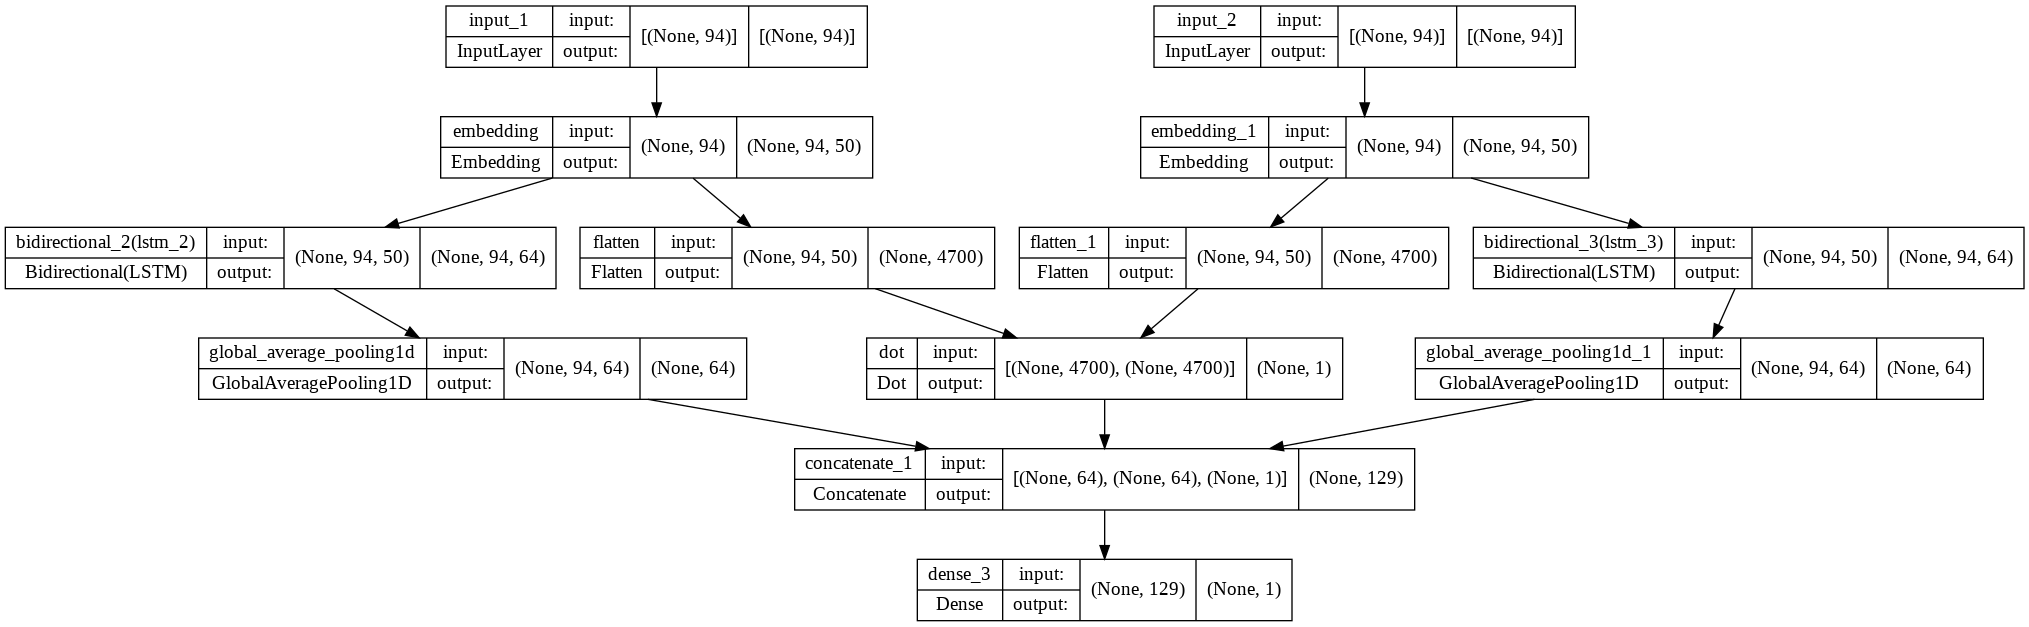

In [ ]:
#averaged lstm, merge conc, cos
merged2=merge_conc(claim_lstm_averaged,evidence_lstm_averaged, c=True)
final_layer2 = Dense(1, activation="sigmoid")(merged2)

model2 = Model(inputs = (claim_input, evidence_input), outputs = final_layer2)
model2.compile(loss = BinaryCrossentropy(from_logits=False), optimizer = Adam(lr_schedule), metrics = ['binary_accuracy'])

model2.summary()

plot_model(model2, show_shapes = True)

In [ ]:
model2.fit(x = (train_mat_claim, train_mat_evidence), y = train_labels,
                   validation_data = ((val_mat_claim, val_mat_evidence), val_labels),
                   batch_size = 128, epochs = 10, callbacks = earlystop)

Epoch 1/10
952/952 [==============================] - 722s 740ms/step - loss: 0.4407 - binary_accuracy: 0.8125 - val_loss: 0.5480 - val_binary_accuracy: 0.7125
Epoch 2/10
952/952 [==============================] - 703s 738ms/step - loss: 0.3993 - binary_accuracy: 0.8320 - val_loss: 0.5602 - val_binary_accuracy: 0.7050
Epoch 3/10
952/952 [==============================] - 696s 732ms/step - loss: 0.3916 - binary_accuracy: 0.8351 - val_loss: 0.5660 - val_binary_accuracy: 0.7140
Epoch 4/10
952/952 [==============================] - 699s 735ms/step - loss: 0.3856 - binary_accuracy: 0.8370 - val_loss: 0.5616 - val_binary_accuracy: 0.7146
Epoch 4: early stopping


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 94, 50)       1778550     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 94, 50)       1778550     ['input_2[0][0]']                
                                                                                            

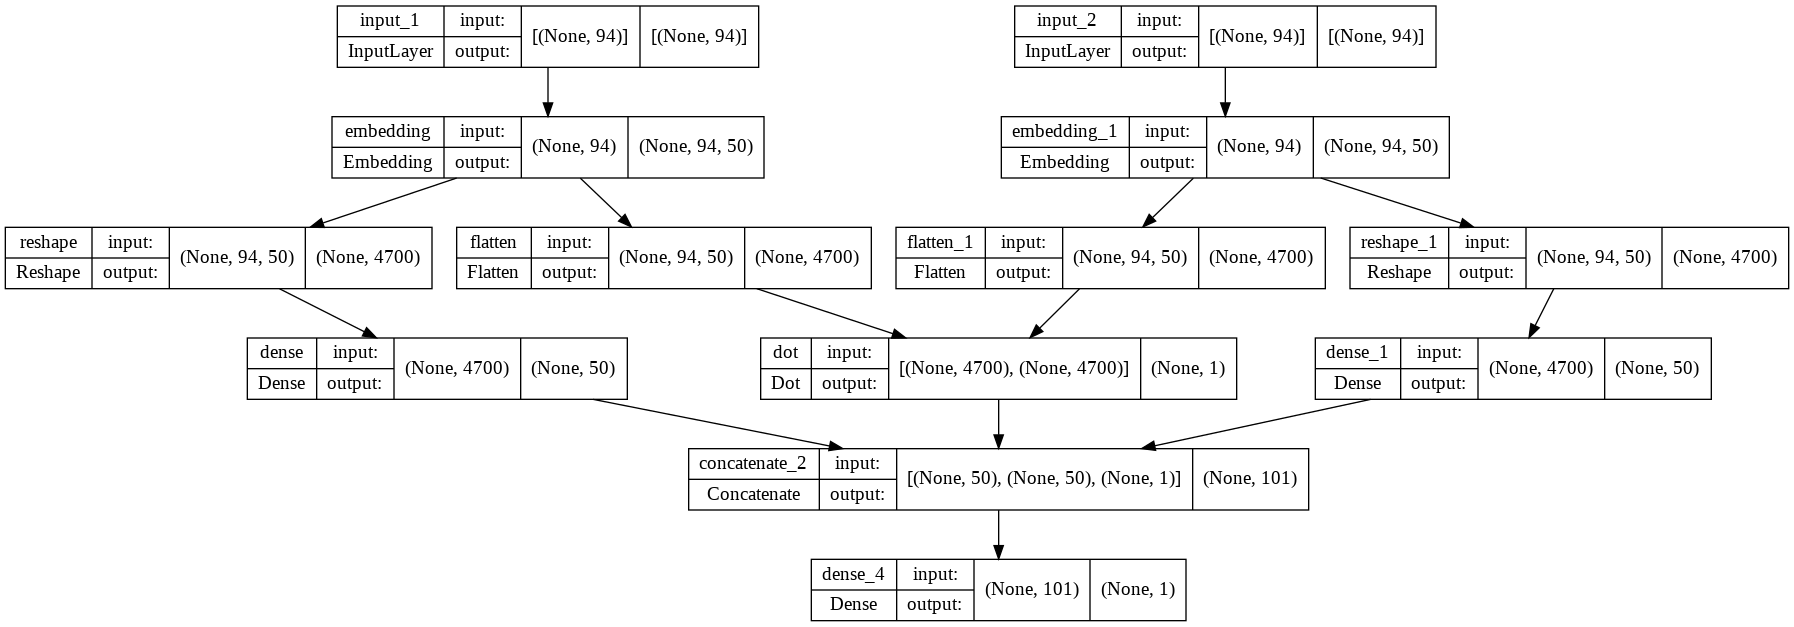

In [ ]:
#mlp, merge conc, cosine
merged3=merge_conc(claim_mlp,evidence_mlp,c=True)
final_layer3 = Dense(1, activation="sigmoid")(merged3)

model3 = Model(inputs = (claim_input, evidence_input), outputs = final_layer3)
model3.compile(loss = BinaryCrossentropy(from_logits=False), optimizer = Adam(lr_schedule), metrics = ['binary_accuracy'])

model3.summary()

plot_model(model3, show_shapes = True)

In [ ]:
model3.fit(x = (train_mat_claim, train_mat_evidence), y = train_labels,
                   validation_data = ((val_mat_claim, val_mat_evidence), val_labels),
                   batch_size = 128, epochs = 10, callbacks = earlystop)

Epoch 1/10
952/952 [==============================] - 20s 20ms/step - loss: 0.5188 - binary_accuracy: 0.7648 - val_loss: 0.7605 - val_binary_accuracy: 0.5669
Epoch 2/10
952/952 [==============================] - 18s 19ms/step - loss: 0.4888 - binary_accuracy: 0.7836 - val_loss: 0.7352 - val_binary_accuracy: 0.5798
Epoch 3/10
952/952 [==============================] - 19s 19ms/step - loss: 0.4783 - binary_accuracy: 0.7892 - val_loss: 0.7190 - val_binary_accuracy: 0.5955
Epoch 4/10
952/952 [==============================] - 19s 19ms/step - loss: 0.4699 - binary_accuracy: 0.7944 - val_loss: 0.7494 - val_binary_accuracy: 0.5913
Epoch 5/10
952/952 [==============================] - 18s 19ms/step - loss: 0.4636 - binary_accuracy: 0.7976 - val_loss: 0.7486 - val_binary_accuracy: 0.5912
Epoch 6/10
952/952 [==============================] - 18s 19ms/step - loss: 0.4569 - binary_accuracy: 0.8010 - val_loss: 0.7184 - val_binary_accuracy: 0.5958
Epoch 7/10
952/952 [==============================] 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 94, 50)       1778550     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 94, 50)       1778550     ['input_2[0][0]']                
                                                                                            

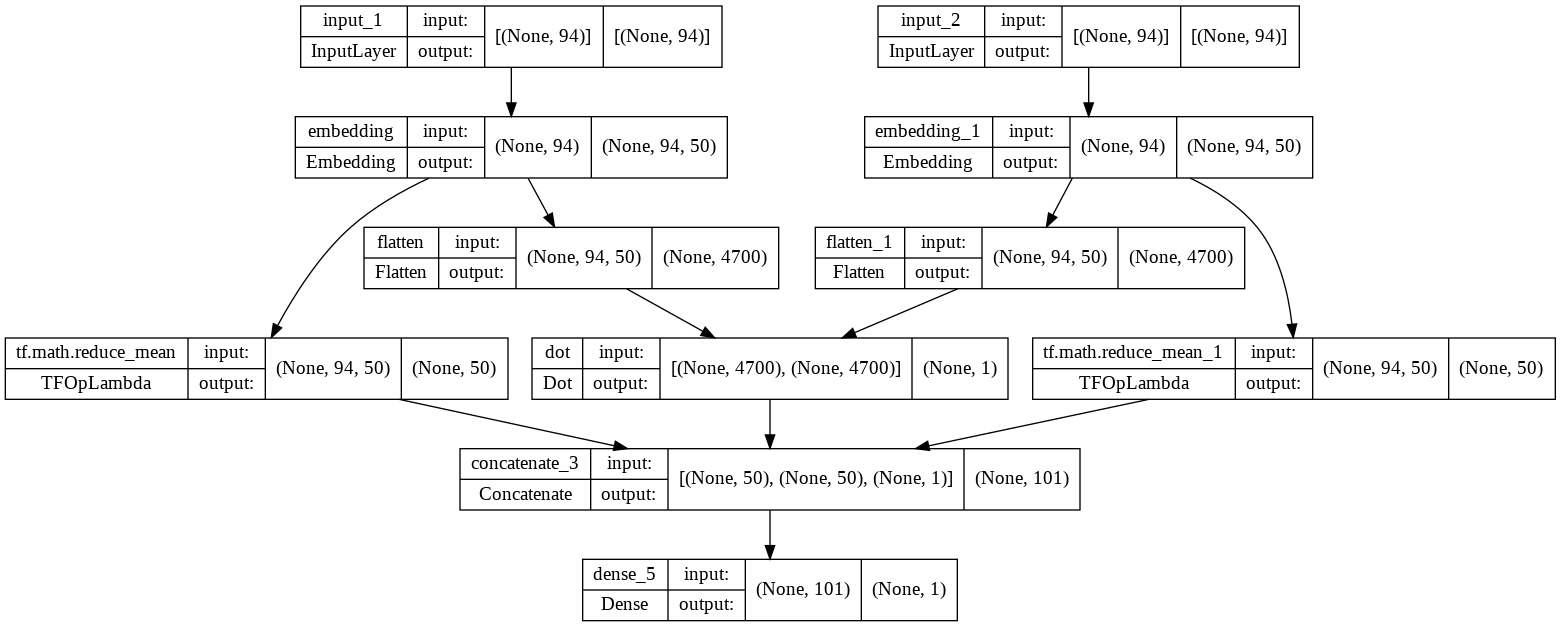

In [ ]:
#merge concat, bag, cos
merged4=merge_conc(claim_bag,evidence_bag,c=True)
final_layer4 = Dense(1, activation="sigmoid")(merged4)

model4 = Model(inputs = (claim_input, evidence_input), outputs = final_layer4)
model4.compile(loss = BinaryCrossentropy(from_logits=False), optimizer = Adam(lr_schedule), metrics = ['binary_accuracy'])

model4.summary()

plot_model(model4, show_shapes = True)

In [ ]:
model4.fit(x = (train_mat_claim, train_mat_evidence), y = train_labels,
                   validation_data = ((val_mat_claim, val_mat_evidence), val_labels),
                   batch_size = 128, epochs = 10, callbacks = earlystop)

Epoch 1/10
952/952 [==============================] - 10s 10ms/step - loss: 0.5627 - binary_accuracy: 0.7344 - val_loss: 0.7582 - val_binary_accuracy: 0.5114
Epoch 2/10
952/952 [==============================] - 9s 10ms/step - loss: 0.5475 - binary_accuracy: 0.7372 - val_loss: 0.7588 - val_binary_accuracy: 0.5218
Epoch 3/10
952/952 [==============================] - 9s 10ms/step - loss: 0.5439 - binary_accuracy: 0.7404 - val_loss: 0.7493 - val_binary_accuracy: 0.5330
Epoch 4/10
952/952 [==============================] - 9s 10ms/step - loss: 0.5425 - binary_accuracy: 0.7420 - val_loss: 0.7473 - val_binary_accuracy: 0.5347
Epoch 5/10
952/952 [==============================] - 9s 10ms/step - loss: 0.5418 - binary_accuracy: 0.7428 - val_loss: 0.7631 - val_binary_accuracy: 0.5326
Epoch 6/10
952/952 [==============================] - 9s 10ms/step - loss: 0.5413 - binary_accuracy: 0.7430 - val_loss: 0.7629 - val_binary_accuracy: 0.5336
Epoch 7/10
952/952 [==============================] - 9s 

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 94, 50)       1778550     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 94, 50)       1778550     ['input_2[0][0]']                
                                                                                            

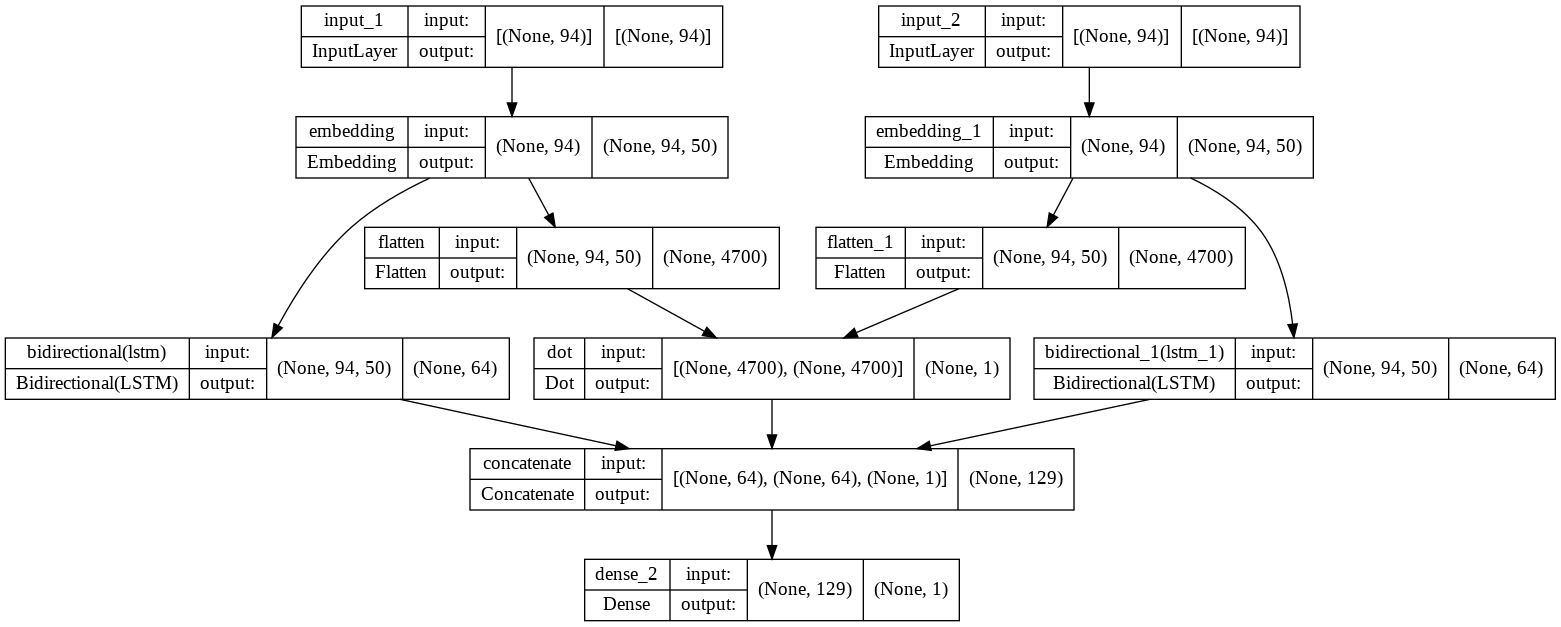

In [ ]:
#lstm last state, merge add, cos
merged=merge_add(claim_lstm,evidence_lstm, c=True)
final_layer = Dense(1, activation="sigmoid")(merged)

model5 = Model(inputs = (claim_input, evidence_input), outputs = final_layer)
model5.compile(loss = BinaryCrossentropy(from_logits=False), optimizer = Adam(lr_schedule), metrics = ['binary_accuracy'])

model5.summary()

plot_model(model, show_shapes = True)

In [ ]:
model5.fit(x = (train_mat_claim, train_mat_evidence), y = train_labels,
                   validation_data = ((val_mat_claim, val_mat_evidence), val_labels),
                   batch_size = 128, epochs = 10, callbacks = earlystop)

Epoch 1/10
952/952 [==============================] - 703s 720ms/step - loss: 0.3925 - binary_accuracy: 0.8339 - val_loss: 0.5441 - val_binary_accuracy: 0.7164
Epoch 2/10
952/952 [==============================] - 694s 729ms/step - loss: 0.3829 - binary_accuracy: 0.8370 - val_loss: 0.5764 - val_binary_accuracy: 0.7087
Epoch 3/10
952/952 [==============================] - 694s 729ms/step - loss: 0.3813 - binary_accuracy: 0.8384 - val_loss: 0.5661 - val_binary_accuracy: 0.7112
Epoch 4/10
952/952 [==============================] - 702s 737ms/step - loss: 0.3804 - binary_accuracy: 0.8386 - val_loss: 0.5559 - val_binary_accuracy: 0.7171
Epoch 4: early stopping


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 94, 50)       1778550     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 94, 50)       1778550     ['input_2[0][0]']                
                                                                                            

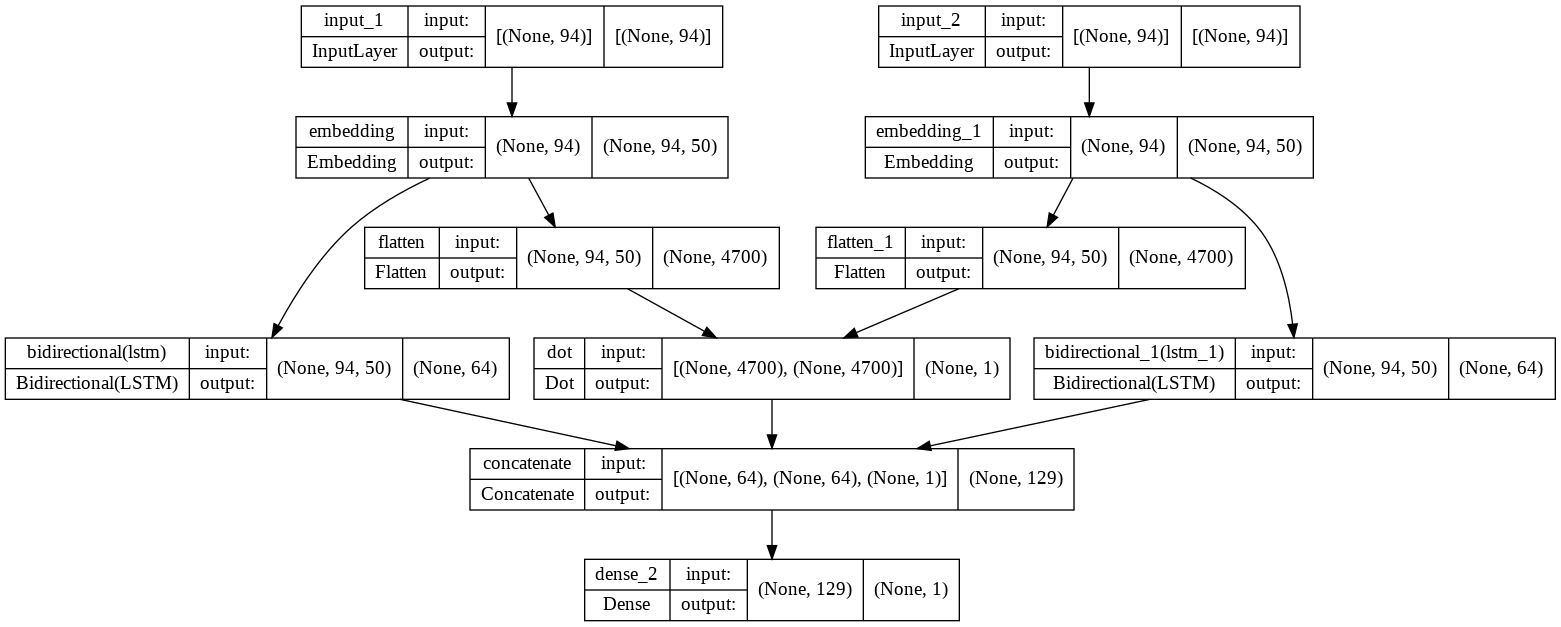

In [ ]:
#lstm last state, merge avg, cos
merged=merge_avg(claim_lstm,evidence_lstm, c=True)
final_layer = Dense(1, activation="sigmoid")(merged)

model6 = Model(inputs = (claim_input, evidence_input), outputs = final_layer)
model6.compile(loss = BinaryCrossentropy(from_logits=False), optimizer = Adam(lr_schedule), metrics = ['binary_accuracy'])

model6.summary()

plot_model(model, show_shapes = True)

In [ ]:
model6.fit(x = (train_mat_claim, train_mat_evidence), y = train_labels,
                   validation_data = ((val_mat_claim, val_mat_evidence), val_labels),
                   batch_size = 128, epochs = 10, callbacks = earlystop)

Epoch 1/10
952/952 [==============================] - 714s 733ms/step - loss: 0.3935 - binary_accuracy: 0.8341 - val_loss: 0.5747 - val_binary_accuracy: 0.7107
Epoch 2/10
952/952 [==============================] - 691s 726ms/step - loss: 0.3840 - binary_accuracy: 0.8374 - val_loss: 0.5563 - val_binary_accuracy: 0.7133
Epoch 3/10
952/952 [==============================] - 695s 730ms/step - loss: 0.3812 - binary_accuracy: 0.8381 - val_loss: 0.5547 - val_binary_accuracy: 0.7150
Epoch 4/10
952/952 [==============================] - 692s 727ms/step - loss: 0.3804 - binary_accuracy: 0.8395 - val_loss: 0.5428 - val_binary_accuracy: 0.7253
Epoch 5/10
952/952 [==============================] - 698s 734ms/step - loss: 0.3793 - binary_accuracy: 0.8390 - val_loss: 0.5742 - val_binary_accuracy: 0.7129
Epoch 6/10
952/952 [==============================] - 698s 733ms/step - loss: 0.3792 - binary_accuracy: 0.8378 - val_loss: 0.5800 - val_binary_accuracy: 0.7093
Epoch 7/10
952/952 [====================

#Evaluate

##A. Multi-input classification evaluation

In [ ]:
def evaluate_model(model):
  y_pred = model.predict((test_mat_claim, test_mat_evidence), batch_size=128, verbose=0)
  y_pred= np.where(y_pred > 0.5, 1, 0) #round the results to 0 or 1 (binary classification)

  print(classification_report(test_labels, y_pred))

evaluate_model(model)
evaluate_model(model2)
evaluate_model(model3)
evaluate_model(model4)
evaluate_model(model5)
evaluate_model(model6)

              precision    recall  f1-score   support

           0       0.87      0.48      0.62      3583
           1       0.64      0.93      0.76      3606

    accuracy                           0.71      7189
   macro avg       0.76      0.71      0.69      7189
weighted avg       0.76      0.71      0.69      7189

              precision    recall  f1-score   support

           0       0.87      0.45      0.60      3583
           1       0.63      0.93      0.75      3606

    accuracy                           0.69      7189
   macro avg       0.75      0.69      0.68      7189
weighted avg       0.75      0.69      0.68      7189

              precision    recall  f1-score   support

           0       0.80      0.25      0.38      3583
           1       0.56      0.94      0.70      3606

    accuracy                           0.59      7189
   macro avg       0.68      0.59      0.54      7189
weighted avg       0.68      0.59      0.54      7189

              preci

## B. Claim verification evaluation

In [ ]:
def vote_model(model):
  y_pred = model.predict((test_mat_claim, test_mat_evidence), batch_size=128, verbose=0)
  y_pred= np.where(y_pred > 0.5, 1, -1) #instead of rounding to 0 we set calues that are not 1 to -1, in this way, during voting, we can can just add up the ints to vote
                                        
  df = pd.DataFrame(columns=(["Claim","Predicted","True"]))
  df["Claim"]=test_data["Claim"].unique() #we want to know, for each unique claim, the results of voting considering all the evidences
  #counting
  D={}
  for i in df["Claim"]:
    D[i]=0
  for k in range(len(test_data["Claim"])):
    D[test_data["Claim"][k]] += int(y_pred[k]) #voting with predicted values
  df["Predicted"]=D.values()

  for i in df["Claim"]:
    D[i]=0
  for k in range(len(test_data["Claim"])):
    D[test_data["Claim"][k]] += int(y_true[k]) #voting with true values
  df["True"]=D.values()

  #given the results of voting, we turn back every label to a binary value, claims with an equal number of evidence for support and rejection (voting=0) are arbitrarly considered fake
  df["Predicted"][df["Predicted"] >1] = 1 
  df["Predicted"][df["Predicted"] <1] = 0  
  df["True"][df["True"] >1] = 1
  df["True"][df["True"] <1] = 0

  print(classification_report(df["True"], df["Predicted"]))

y_true = np.where(test_labels> 0.5, 1, -1 )
vote_model(model)
vote_model(model2)
vote_model(model3)
vote_model(model4)
vote_model(model5)
vote_model(model6)

              precision    recall  f1-score   support

           0       0.87      0.48      0.62      3250
           1       0.64      0.93      0.76      3270

    accuracy                           0.70      6520
   macro avg       0.75      0.70      0.69      6520
weighted avg       0.75      0.70      0.69      6520

              precision    recall  f1-score   support

           0       0.87      0.45      0.60      3250
           1       0.63      0.93      0.75      3270

    accuracy                           0.69      6520
   macro avg       0.75      0.69      0.67      6520
weighted avg       0.75      0.69      0.67      6520

              precision    recall  f1-score   support

           0       0.80      0.25      0.38      3250
           1       0.56      0.94      0.70      3270

    accuracy                           0.59      6520
   macro avg       0.68      0.59      0.54      6520
weighted avg       0.68      0.59      0.54      6520

              preci